# Backtesting with backtrader library
Notes:  
Timestamp must be in the exact format specified for datafeed   **Timestamp needs to be first column index**  
Params for datafeed need to be specified as tuple of tuples  
Within strategy data is accessed via self.datas[0] for ex: self.datas[0].high_delta[0] would get you the first timeperiod's high_delta  
The current data has already happened and cannot be used to execute an order (ex. you cannot look at the current close price and simultaneously buy the current close, the order will be executed at open instead), orders will be executed on the following day.

In [1]:
import backtrader as bt
import datetime
import pandas as pd

## Define Strategies and Data utils

In [2]:
class BasicStrategy(bt.Strategy):
    def __init__(self):
        # To keep track of pending orders
        self.order = None
        print('***The limit sells for this strategy are valid for 1 day***')
        
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        elif order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
            self.bar_executed = len(self)
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        # set no pending order
        self.order = None


    def next(self):
        # STRATEGY 
        data = self.datas[0]
        self.log(f'Current Portfolio Value : {self.broker.get_value()}')
        
        # cancel if there is an order pending, this strategy should have 1 working order per day
        if self.order:
            self.log('ORDER CANCELLED')
            self.cancel(self.order)
        
        # Check if we are in the market
        if not self.position:
            # BUY
            try:
                self.size = int(self.broker.get_cash() / self.datas[0].open[1])
            except:
                print('Size Exception. If at the end of data, ignore.')
            # get in position ASAP
            self.log(f'MARKET BUY CREATE {self.size} shares at next open, current close price: {data.close[0]}')
            self.buy(size=self.size) # market order buys at next open                      
                
        else:
            # place sell order at predicted high if predicted high is greater than current close price
            # TODO: Make prediction and close a filter in the class constructor (more optimal)
            if data.prediction[0] >= data.close[0]:
                self.log(f'LIMIT SELL CREATE {self.size} shares at {data.prediction[0]}')  
                self.sell(exectype=bt.Order.Limit,
                             price=data.prediction[0],
                             valid=data.datetime.date(0) + datetime.timedelta(days=2),
                             size=self.size)
        # if prediction is less than current value sell at open (ASAP)
            else:
                self.log('MARKET SELL CREATE. PREDICTION < CURRENT CLOSE')
                self.sell(size=self.size)
        

In [3]:
class BuyAndHold(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def start(self):
        # Track orders with this, dict must be named order_statistics_dict
        order_statistics_dict = {'timestamp':[], 'open':[], 'high':[],
                                    'low':[], 'close':[], 'volume':[], 'buy':[], 'sell':[]}

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)
      
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        size = int(self.broker.get_cash() / self.datas[0].open[1])
        self.buy(size=size)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print(f'Stop price: {self.datas[0].close[0]}')
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

In [4]:
def prepare_data(data, fromdate, todate, filepath):
    """Prepare data for backtrader datafeed object
        Returns prepared data filepath and params for the GenericCSVData class, also returns columns used"""
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    # start param setup for backtrader
    start = data['timestamp'].iloc[0]
    end = data['timestamp'].iloc[-1]
    from_to = [(start.year, start.month, start.day), (end.year, end.month, end.day)]
    # Backtrader string format
    data['timestamp'] = data['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    # backtrader data feed class needs a file path, this could be a temp file that's constantly overwritten
    data.to_csv(filepath)
    
    starting_params = [
    ('fromdate', datetime.datetime(*from_to[0])),
    ('todate', datetime.datetime(*from_to[1])),
    ('nullvalue', 0.0),
    ('dtformat', ('%Y-%m-%d %H:%M:%S')),
    ('tmformat', ('%H:%M:%S')),
    ('datetime', 1)]
    # skip nonfeatures (timestamp)
    cols = data.columns[1:]
    # get column position for each indicator and add to starting params list
    i = 2 # starting index since others are reserved
    for indicator in cols:
        starting_params.append((indicator, i))
        i+=1
    final_params = tuple(starting_params)

    return filepath, final_params, cols 

## Import Data and Run Backtest

In [5]:
import os

In [6]:
def capstone_data_prep(pred_folder_name, pred_col_name, ticker_df_filepath, starting_cash=100000):
    """Main loop, preps data and executes backtrader on all stocks in the prediction folder"""
    ticker_backtesting_dict = {}
    for pred_file in os.listdir(f'../data/ticker_predictions/{pred_folder_name}'):
        # collect data
        ticker_name = pred_file.split('_')[0]
        pred_df = pd.read_csv(f'../data/ticker_predictions/{pred_folder_name}/{pred_file}')
        ticker_df = pd.read_csv(ticker_df_filepath + f'/{ticker_name}_full_data.csv')
        
        # make timestamp in column position 0, SPECIFIC TO FULL DATA IN FILE 
        ticker_df = ticker_df.rename({'reportperiod':'timestamp'}, axis=1)
        ticker_cols = list(ticker_df.columns)
        ticker_cols[5] = 'ts_cpy'
        ticker_cols[0] = 'timestamp'
        ticker_df.columns = ticker_cols
        ticker_df['timestamp'] = ticker_df['ts_cpy']
        # merge prediction data with full data, on key = timestamp
        ticker_df = ticker_df.merge(pred_df.loc[:, ['timestamp', pred_col_name]], on='timestamp')
        # new prediction column name = "prediction", important because backtester strategy looks for this column name
        ticker_df = ticker_df.rename({pred_col_name:'prediction'}, axis=1)
        # remove all non-prediction rows in prediction field
        ticker_df = ticker_df[ticker_df.prediction > 0]
        # skip nonfeatures, keep timestamp, SPECIFIC TO FULL DATA IN FILE 
        nonfeatures = ticker_df.columns[1:7]
        features = [col for col in ticker_df.columns if col not in nonfeatures]
        # get index of start and end dates for trading
        ticker_df = ticker_df[features]
        ticker_df.columns = [c.lower() for c in ticker_df.columns]
        idx1 = ticker_df.prediction[ticker_df.prediction > 0].index[0]
        idx2 = ticker_df.prediction[ticker_df.prediction > 0].index[-1]
        start_date = pred_df.timestamp[idx1]
        end_date  = pred_df.timestamp[idx2]
        
        # Prepare data for backtrader
        prep_data = prepare_data(ticker_df.copy(), start_date, end_date, 'temp/prep_data.csv')
        class DataFeed(bt.feeds.GenericCSVData):
            lines = tuple(prep_data[2])
            params = prep_data[1]
        
        print(f"--------Ticker Name-------: {ticker_name}")
        ##### BUY AND HOLD #######
        print('BUY AND HOLD')
        # initialize everything and run strategy
        cerebro = bt.Cerebro(cheat_on_open=True)
        cerebro.broker.setcash(starting_cash)
        #cerebro.addsizer(bt.sizers.FixedSize, stake=10)
        print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')
        data = DataFeed(dataname=prep_data[0])
        cerebro.adddata(data)
        cerebro.addstrategy(BuyAndHold)
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Months, _name = 'sharpe')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'dd')
        cerebro.addanalyzer(bt.analyzers.Returns, _name = 'returns')
        buy_hold = cerebro.run()
        buy_hold_ret = cerebro.broker.getvalue() / starting_cash - 1
        print(f'Final Portfolio Value: {cerebro.broker.getvalue()}\n')
        print('STRATEGY INFO:')
        print(buy_hold[0].analyzers.sharpe.get_analysis())
        print(buy_hold[0].analyzers.dd.get_analysis())
        # rtot is total log returns over the strategy time period
        print(buy_hold[0].analyzers.returns.get_analysis())

        #### MAIN STRATEGY ####
        cerebro = bt.Cerebro(cheat_on_open=True)
        cerebro.broker.setcash(starting_cash)
        print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')
        data = DataFeed(dataname=prep_data[0])
        cerebro.adddata(data)
        cerebro.addstrategy(BasicStrategy)
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Months, _name = 'sharpe')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'dd')
        cerebro.addanalyzer(bt.analyzers.Returns, _name = 'returns')
        back = cerebro.run()
        strat_ret = cerebro.broker.getvalue() / starting_cash - 1
        print(f'Final Portfolio Value: {cerebro.broker.getvalue()}\n')
        print('STRATEGY INFO:')
        print(back[0].analyzers.sharpe.get_analysis())
        print(back[0].analyzers.dd.get_analysis())
        # rtot is total log returns over the strategy time period
        print(back[0].analyzers.returns.get_analysis())
        print(f"For {ticker_name}, return was {buy_hold_ret*100}% for buy and hold vs {strat_ret*100}%  for strategy")
        print('\n'*5)

        ticker_backtesting_dict[ticker_name] = cerebro
        
    return ticker_backtesting_dict

In [7]:
cerebro_dict = capstone_data_prep('xgboost_preds', 'holdout_preds', '../data/ticker_data')

--------Ticker Name-------: ADSK
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-19, BUY EXECUTED, 151.39
Stop price: 329.07000732421875
ROI:        117.27%
Final Portfolio Value: 217268.8052368164

STRATEGY INFO:
OrderedDict([('sharperatio', 0.35206001119841246)])
AutoOrderedDict([('len', 52), ('drawdown', 3.8551895466552977), ('moneydown', 8711.987915039062), ('max', AutoOrderedDict([('len', 136), ('drawdown', 35.45057378420961), ('moneydown', 49341.59637451175)]))])
OrderedDict([('rtot', 0.7759651347648641), ('ravg', 0.0014343163304341294), ('rnorm', 0.4354059702078554), ('rnorm100', 43.54059702078554)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-18, Current Portfolio Value : 100000.0
2019-09-18, MARKET BUY CREATE 660 shares at next open, current close price: 151.11000061035156
2019-09-19, BUY EXECUTED, 151.39
2019-09-19, Current Portfolio Value : 101313.40362548828
2019-09-19, MARKET SELL CREATE. PREDICTION < CURRENT C

2020-07-15, SELL EXECUTED, 236.00
2020-07-15, Current Portfolio Value : 229254.65946474447
2020-07-15, MARKET BUY CREATE 980 shares at next open, current close price: 235.5800018310547
2020-07-16, BUY EXECUTED, 233.86
2020-07-16, Current Portfolio Value : 229421.25767031085
2020-07-16, LIMIT SELL CREATE 980 shares at 238.70424361511502
2020-07-17, Current Portfolio Value : 233017.85587587726
2020-07-17, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-07-20, SELL EXECUTED, 239.05
2020-07-20, Current Portfolio Value : 234340.86185732257
2020-07-20, MARKET BUY CREATE 950 shares at next open, current close price: 246.0399932861328
2020-07-21, BUY EXECUTED, 246.64
2020-07-21, Current Portfolio Value : 227738.3647564925
2020-07-21, LIMIT SELL CREATE 950 shares at 249.28438852993716
2020-07-22, Current Portfolio Value : 228735.86765566244
2020-07-22, LIMIT SELL CREATE 950 shares at 242.86875070114186
2020-07-23, SELL EXECUTED, 242.87
2020-07-23, Current Portfolio Value : 230758.1756032413

2021-04-05, SELL EXECUTED, 285.74
2021-04-05, Current Portfolio Value : 270871.09653905506
2021-04-05, MARKET BUY CREATE 944 shares at next open, current close price: 288.32000732421875
2021-04-06, BUY EXECUTED, 286.86
2021-04-06, Current Portfolio Value : 269587.27036718006
2021-04-06, LIMIT SELL CREATE 944 shares at 292.48962084871886
2021-04-07, Current Portfolio Value : 270172.54575780506
2021-04-07, LIMIT SELL CREATE 944 shares at 289.6233857870102
2021-04-08, SELL EXECUTED, 290.00
2021-04-08, Current Portfolio Value : 273835.27036718006
2021-04-08, MARKET BUY CREATE 935 shares at next open, current close price: 293.42999267578125
2021-04-09, BUY EXECUTED, 292.56
2021-04-09, Current Portfolio Value : 278519.62949803943
2021-04-09, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-04-12, SELL EXECUTED, 294.00
2021-04-12, Current Portfolio Value : 275181.6726498949
2021-04-12, MARKET BUY CREATE 931 shares at next open, current close price: 294.5
2021-04-13, BUY EXECUTED, 295.34
20

--------Ticker Name-------: HD
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-19, BUY EXECUTED, 231.15
Stop price: 368.5899963378906
ROI:        59.37%
Final Portfolio Value: 159374.0810546875

STRATEGY INFO:
OrderedDict([('sharperatio', 0.266248586298018)])
AutoOrderedDict([('len', 8), ('drawdown', 1.0009381519418883), ('moneydown', 1611.36474609375), ('max', AutoOrderedDict([('len', 143), ('drawdown', 38.354331184162646), ('moneydown', 40983.84448242186)]))])
OrderedDict([('rtot', 0.4660839639766037), ('ravg', 0.0008615230387737592), ('rnorm', 0.2424730713188748), ('rnorm100', 24.24730713188748)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-18, Current Portfolio Value : 100000.0
2019-09-18, MARKET BUY CREATE 432 shares at next open, current close price: 230.8300018310547
2019-09-19, BUY EXECUTED, 231.15
2019-09-19, Current Portfolio Value : 98691.04052734374
2019-09-19, LIMIT SELL CREATE 432 shares at 232.73308312018344


2020-07-06, Current Portfolio Value : 143994.12470468078
2020-07-06, LIMIT SELL CREATE 577 shares at 250.548761844635
2020-07-07, SELL EXECUTED, 250.55
2020-07-07, Current Portfolio Value : 144570.40852817093
2020-07-07, MARKET BUY CREATE 583 shares at next open, current close price: 247.3500061035156
2020-07-08, BUY EXECUTED, 247.87
2020-07-08, Current Portfolio Value : 145328.31030734573
2020-07-08, LIMIT SELL CREATE 583 shares at 249.38928680683603
2020-07-09, SELL EXECUTED, 249.66
2020-07-09, Current Portfolio Value : 145613.98350986038
2020-07-09, MARKET BUY CREATE 586 shares at next open, current close price: 247.9600067138672
2020-07-10, BUY EXECUTED, 248.29
2020-07-10, Current Portfolio Value : 146680.5078018526
2020-07-10, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-07-13, SELL EXECUTED, 251.92
2020-07-13, Current Portfolio Value : 147741.1663711885
2020-07-13, MARKET BUY CREATE 593 shares at next open, current close price: 249.6199951171875
2020-07-14, BUY EXECUTED, 2

2021-03-22, SELL EXECUTED, 286.50
2021-03-22, Current Portfolio Value : 157939.4661931111
2021-03-22, MARKET BUY CREATE 545 shares at next open, current close price: 288.94000244140625
2021-03-23, BUY EXECUTED, 289.61
2021-03-23, Current Portfolio Value : 158141.13016405836
2021-03-23, LIMIT SELL CREATE 545 shares at 291.3221724711475
2021-03-24, SELL EXECUTED, 291.32
2021-03-24, Current Portfolio Value : 158872.6081732849
2021-03-24, MARKET BUY CREATE 542 shares at next open, current close price: 292.75
2021-03-25, BUY EXECUTED, 293.03
2021-03-25, Current Portfolio Value : 161121.90486517944
2021-03-25, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-03-26, SELL EXECUTED, 297.34
2021-03-26, Current Portfolio Value : 161208.62685004272
2021-03-26, MARKET BUY CREATE 531 shares at next open, current close price: 303.80999755859375
2021-03-29, BUY EXECUTED, 303.30
2021-03-29, Current Portfolio Value : 160624.5398139099
2021-03-29, LIMIT SELL CREATE 531 shares at 306.31476347817807
202

--------Ticker Name-------: MSFT
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-17, BUY EXECUTED, 136.96
Stop price: 336.989990234375
ROI:        146.02%
Final Portfolio Value: 246021.8879699707

STRATEGY INFO:
OrderedDict([('sharperatio', 0.6016758942743915)])
AutoOrderedDict([('len', 0), ('drawdown', 0.0), ('moneydown', 0.0), ('max', AutoOrderedDict([('len', 98), ('drawdown', 28.23135999038539), ('moneydown', 38894.39910888675)]))])
OrderedDict([('rtot', 0.9002503214738733), ('ravg', 0.0016579195607253651), ('rnorm', 0.5186104351045537), ('rnorm100', 51.861043510455374)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 730 shares at next open, current close price: 136.33000183105472
2019-09-17, BUY EXECUTED, 136.96
2019-09-17, Current Portfolio Value : 100313.8946533203
2019-09-17, LIMIT SELL CREATE 730 shares at 137.58915899775823
2019-09-18, SELL EXECUTED

2020-07-02, MARKET BUY CREATE 833 shares at next open, current close price: 206.25999450683597
2020-07-06, BUY EXECUTED, 208.83
2020-07-06, Current Portfolio Value : 175599.01198679768
2020-07-06, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-07-07, SELL EXECUTED, 210.45
2020-07-07, Current Portfolio Value : 175390.76198679768
2020-07-07, MARKET BUY CREATE 834 shares at next open, current close price: 208.25
2020-07-08, BUY EXECUTED, 210.07
2020-07-08, Current Portfolio Value : 177692.59740549885
2020-07-08, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-07-09, SELL EXECUTED, 216.33
2020-07-09, Current Portfolio Value : 180611.59740549885
2020-07-09, MARKET BUY CREATE 845 shares at next open, current close price: 214.32000732421875
2020-07-10, BUY EXECUTED, 213.62
2020-07-10, Current Portfolio Value : 180653.8499842342
2020-07-10, LIMIT SELL CREATE 845 shares at 215.96597196481892
2020-07-13, Current Portfolio Value : 175076.85772044025
2020-07-13, LIMIT SELL CREATE 845 shar

2021-04-13, Current Portfolio Value : 215330.01409773494
2021-04-13, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-04-14, SELL EXECUTED, 257.48
2021-04-14, Current Portfolio Value : 214488.70138411183
2021-04-14, MARKET BUY CREATE 831 shares at next open, current close price: 255.58999633789062
2021-04-15, BUY EXECUTED, 257.93
2021-04-15, Current Portfolio Value : 215793.3774705376
2021-04-15, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-04-16, SELL EXECUTED, 259.47
2021-04-16, Current Portfolio Value : 215768.44848494185
2021-04-16, MARKET BUY CREATE 829 shares at next open, current close price: 260.739990234375
2021-04-19, BUY EXECUTED, 260.19
2021-04-19, Current Portfolio Value : 214566.38836531295
2021-04-19, LIMIT SELL CREATE 829 shares at 262.7424575246405
2021-04-20, Current Portfolio Value : 214168.4845567192
2021-04-20, LIMIT SELL CREATE 829 shares at 260.73443856817903
2021-04-21, Current Portfolio Value : 216091.74532942422
2021-04-21, MARKET SELL CREATE. PREDIC

--------Ticker Name-------: UNH
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-17, BUY EXECUTED, 233.07
Stop price: 462.6199951171875
ROI:        98.48%
Final Portfolio Value: 198476.9447631836

STRATEGY INFO:
OrderedDict([('sharperatio', 0.37845508708599584)])
AutoOrderedDict([('len', 0), ('drawdown', 0.0), ('moneydown', 0.0), ('max', AutoOrderedDict([('len', 70), ('drawdown', 36.172763529816756), ('moneydown', 47383.048690795884)]))])
OrderedDict([('rtot', 0.6855027601047875), ('ravg', 0.0012624360222924264), ('rnorm', 0.3745602717643974), ('rnorm100', 37.45602717643974)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 429 shares at next open, current close price: 234.42999267578125
2019-09-17, BUY EXECUTED, 233.07
2019-09-17, Current Portfolio Value : 99764.04869079588
2019-09-17, LIMIT SELL CREATE 429 shares at 237.0148515394394
2019-09-18, Current Portf

2020-07-09, Current Portfolio Value : 131798.28933138162
2020-07-09, LIMIT SELL CREATE 452 shares at 301.0205958729057
2020-07-10, Current Portfolio Value : 131829.9326419285
2020-07-10, LIMIT SELL CREATE 452 shares at 294.6358300550856
2020-07-13, Current Portfolio Value : 135662.8838138035
2020-07-13, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-07-14, SELL EXECUTED, 297.81
2020-07-14, Current Portfolio Value : 134804.08657259255
2020-07-14, MARKET BUY CREATE 447 shares at next open, current close price: 308.5199890136719
2020-07-15, BUY EXECUTED, 301.12
2020-07-15, Current Portfolio Value : 136122.74202913552
2020-07-15, LIMIT SELL CREATE 447 shares at 312.0726768229906
2020-07-16, Current Portfolio Value : 137499.49602693826
2020-07-16, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-07-17, SELL EXECUTED, 309.09
2020-07-17, Current Portfolio Value : 138366.67711824685
2020-07-17, MARKET BUY CREATE 451 shares at next open, current close price: 306.5299987792969
2020-07-20

2021-04-20, SELL EXECUTED, 394.58
2021-04-20, Current Portfolio Value : 154873.65572596
2021-04-20, MARKET BUY CREATE 388 shares at next open, current close price: 396.5299987792969
2021-04-21, BUY EXECUTED, 398.86
2021-04-21, Current Portfolio Value : 154854.26046228813
2021-04-21, LIMIT SELL CREATE 388 shares at 400.04982194532204
2021-04-22, Current Portfolio Value : 153973.50472498345
2021-04-22, LIMIT SELL CREATE 388 shares at 402.3500592754135
2021-04-23, Current Portfolio Value : 155436.26046228813
2021-04-23, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-04-26, SELL EXECUTED, 399.81
2021-04-26, Current Portfolio Value : 155242.26046228813
2021-04-26, MARKET BUY CREATE 393 shares at next open, current close price: 395.8599853515625
2021-04-27, BUY EXECUTED, 394.66
2021-04-27, Current Portfolio Value : 155179.37902307915
2021-04-27, LIMIT SELL CREATE 393 shares at 399.3738611017761
2021-04-28, Current Portfolio Value : 155214.74758387016
2021-04-28, LIMIT SELL CREATE 393 sh

--------Ticker Name-------: WAT
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-17, BUY EXECUTED, 231.57
Stop price: 349.9200134277344
ROI:        51.01%
Final Portfolio Value: 151008.85263061523

STRATEGY INFO:
OrderedDict([('sharperatio', 0.2239510269051301)])
AutoOrderedDict([('len', 43), ('drawdown', 17.58914522943871), ('moneydown', 32230.179473876953), ('max', AutoOrderedDict([('len', 227), ('drawdown', 33.42213142300035), ('moneydown', 37053.07052612305)]))])
OrderedDict([('rtot', 0.41216827580117166), ('ravg', 0.0007590575981605371), ('rnorm', 0.21080147302509772), ('rnorm100', 21.080147302509772)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 431 shares at next open, current close price: 231.5200042724609
2019-09-17, BUY EXECUTED, 231.57
2019-09-17, Current Portfolio Value : 98758.71789550781
2019-09-17, LIMIT SELL CREATE 431 shares at 233.74569746

2020-07-02, SELL EXECUTED, 182.50
2020-07-02, Current Portfolio Value : 93417.24995459634
2020-07-02, MARKET BUY CREATE 510 shares at next open, current close price: 180.82000732421875
2020-07-06, BUY EXECUTED, 182.89
2020-07-06, Current Portfolio Value : 94166.95057715494
2020-07-06, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-07-07, SELL EXECUTED, 182.95
2020-07-07, Current Portfolio Value : 93447.84870947915
2020-07-07, MARKET BUY CREATE 502 shares at next open, current close price: 185.33999633789062
2020-07-08, BUY EXECUTED, 186.03
2020-07-08, Current Portfolio Value : 92955.89085425454
2020-07-08, LIMIT SELL CREATE 502 shares at 187.23676554508347
2020-07-09, SELL EXECUTED, 187.24
2020-07-09, Current Portfolio Value : 94053.64562590403
2020-07-09, MARKET BUY CREATE 498 shares at next open, current close price: 188.6300048828125
2020-07-10, BUY EXECUTED, 188.64
2020-07-10, Current Portfolio Value : 94108.4259298591
2020-07-10, LIMIT SELL CREATE 498 shares at 190.5202157748

2021-03-26, SELL EXECUTED, 274.50
2021-03-26, Current Portfolio Value : 136300.06218396407
2021-03-26, MARKET BUY CREATE 488 shares at next open, current close price: 281.22000122070307
2021-03-29, BUY EXECUTED, 278.92
2021-03-29, Current Portfolio Value : 138788.85026990154
2021-03-29, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-03-30, SELL EXECUTED, 284.14
2021-03-30, Current Portfolio Value : 138847.42277966716
2021-03-30, MARKET BUY CREATE 490 shares at next open, current close price: 282.510009765625
2021-03-31, BUY EXECUTED, 282.97
2021-03-31, Current Portfolio Value : 139435.42876111247
2021-03-31, LIMIT SELL CREATE 490 shares at 285.2258900067245
2021-04-01, SELL EXECUTED, 285.23
2021-04-01, Current Portfolio Value : 139952.80828481764
2021-04-01, MARKET BUY CREATE 485 shares at next open, current close price: 284.7200012207031
2021-04-05, BUY EXECUTED, 288.33
2021-04-05, Current Portfolio Value : 143503.01183706374
2021-04-05, MARKET SELL CREATE. PREDICTION < CURRENT C

--------Ticker Name-------: XOM
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-17, BUY EXECUTED, 73.82
Stop price: 65.72000122070311
ROI:        -10.97%
Final Portfolio Value: 89032.60206604002

STRATEGY INFO:
OrderedDict([('sharperatio', 0.007655329138823791)])
AutoOrderedDict([('len', 542), ('drawdown', 10.967397933959974), ('moneydown', 10967.397933959975), ('max', AutoOrderedDict([('len', 542), ('drawdown', 57.368978553771974), ('moneydown', 57368.97855377197)]))])
OrderedDict([('rtot', -0.11616756798427419), ('ravg', -0.0002139365892896394), ('rnorm', -0.05248453522926926), ('rnorm100', -5.248453522926926)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 1354 shares at next open, current close price: 73.7300033569336
2019-09-17, BUY EXECUTED, 73.82
2019-09-17, Current Portfolio Value : 99119.89793395996
2019-09-17, LIMIT SELL CREATE 1354 shares at 74.29

2020-07-15, Current Portfolio Value : 77339.44577553576
2020-07-15, MARKET BUY CREATE 1745 shares at next open, current close price: 44.63000106811523
2020-07-16, BUY EXECUTED, 44.31
2020-07-16, Current Portfolio Value : 77287.091249016
2020-07-16, LIMIT SELL CREATE 1745 shares at 45.04275609408205
2020-07-17, Current Portfolio Value : 75960.89417794054
2020-07-17, LIMIT SELL CREATE 1745 shares at 44.69011333288654
2020-07-20, Current Portfolio Value : 74180.99337914294
2020-07-20, LIMIT SELL CREATE 1745 shares at 43.942805943167976
2020-07-21, SELL EXECUTED, 43.94
2020-07-21, Current Portfolio Value : 76698.68974997105
2020-07-21, MARKET BUY CREATE 1737 shares at next open, current close price: 44.650001525878906
2020-07-22, BUY EXECUTED, 44.15
2020-07-22, Current Portfolio Value : 75760.70815970005
2020-07-22, LIMIT SELL CREATE 1737 shares at 45.06354298812767
2020-07-23, Current Portfolio Value : 75917.03842474522
2020-07-23, LIMIT SELL CREATE 1737 shares at 44.013909743716795
2020-

2021-04-01, SELL EXECUTED, 57.34
2021-04-01, Current Portfolio Value : 101742.92577853278
2021-04-01, MARKET BUY CREATE 1775 shares at next open, current close price: 57.38999938964844
2021-04-05, BUY EXECUTED, 57.30
2021-04-05, Current Portfolio Value : 100322.92713275031
2021-04-05, LIMIT SELL CREATE 1775 shares at 58.019396443825826
2021-04-06, Current Portfolio Value : 100038.92740359381
2021-04-06, LIMIT SELL CREATE 1775 shares at 57.11963641643524
2021-04-07, Current Portfolio Value : 100482.67740359381
2021-04-07, LIMIT SELL CREATE 1775 shares at 56.9834640496515
2021-04-08, Current Portfolio Value : 99435.42713275031
2021-04-08, LIMIT SELL CREATE 1775 shares at 57.21062360215638
2021-04-09, Current Portfolio Value : 99204.67523684578
2021-04-09, LIMIT SELL CREATE 1775 shares at 56.6141529083252
2021-04-12, Current Portfolio Value : 98547.92713275031
2021-04-12, LIMIT SELL CREATE 1775 shares at 56.50809490533676
2021-04-13, Current Portfolio Value : 98920.67550768927
2021-04-13,

### Library additionally has plotting
Creating a customized plot seems annoying, documentation talks about keeping statistics at the bottom
https://www.backtrader.com/docu/observers-and-statistics/observers-and-statistics/

<IPython.core.display.Javascript object>


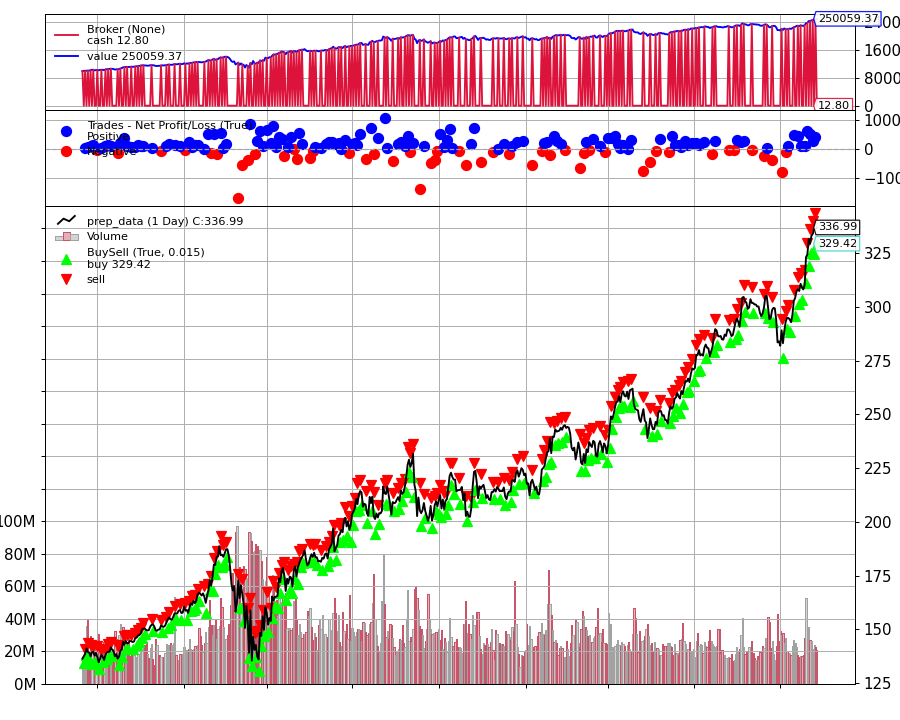

[[<Figure size 720x576 with 4 Axes>]]

In [14]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 12})
cerebro_dict['MSFT'].plot()
# set iplot = False to not plot inline

### Ways to Improve:

Increase strategy trading volume. There are certain periods where sell orders are not going through for multiple days in a row, meaning that the price is lower than anticipated by model for that period. For example, if the last sell order didn't go through, we can find a way to use that information to inform our next sell order and make the prediction lower or try a market sell. Maybe train a "bear" model, one that only knows pain and suffering of bear markets, and only produces pessimistic high price predictions.   

Smarter entry points. Currently, buy orders are being executed at market price at the open (getting in position ASAP when not in a position). Returns may increase if entry constraints are increased.  

Resizing orders. Orders for this strategy baseline are currently 100% in or 100% out of position. This has beneifits if you want less exposure to the long term movement of the stocks. Depending on the situation and strategy, we might want to reserve a cash position to expose ourselves less to short term movements.  